<h1><center>Credit Risk Analysis using IBM PowerAI Snap ML</center></h1>

In this example we will train a Logistic Regression model on customers' credit history dataset, using both scikit-learn and snap-ml-local.
Update device_ids list in LogisticRegression of snap_ml based on the number of GPUs available for you.

To avoid 'kernel restart' problem increase CPU and memory for the jupyter environment (e.g. memory 10GB, CPU 100) and restart it

### Download input dataset of customers' information

Two wget commands are given below for downloading input dataset - one for reduced dataset and another for bigger/full dataset. Many times better perfomance of snapML training is seen with bigger dataset.

You can comment out downloading code below if running the same wget command more than once.

In [1]:
# Many times better training time with snapML compared to sklearn with this full dataset
#!wget -O credit_customer_history.csv -nc https://ibm.box.com/shared/static/c84jns0hy2ty05t3c3a9c17ca1mxpe6s.csv

# Download reduced dataset
!wget -O credit_customer_history.csv https://ibm.box.com/shared/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv

--2020-02-22 09:11:47--  https://ibm.box.com/shared/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv
Resolving ibm.box.com (ibm.box.com)... 103.116.4.197
Connecting to ibm.box.com (ibm.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv [following]
--2020-02-22 09:11:47--  https://ibm.box.com/public/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv [following]
--2020-02-22 09:11:48--  https://ibm.ent.box.com/public/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv
Resolving ibm.ent.box.com (ibm.ent.box.com)... 103.116.4.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|103.116.4.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!VU

### imports

In [31]:
from __future__ import print_function
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.utils import shuffle
import GPUtil as GPU
import time

import warnings
warnings.filterwarnings('ignore')


In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [ ]:
# Check your GPU

In [39]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 7156MB | Used: 955MB | Util  12% | Total 8111MB


# Dataset Visualization


Let's take a quick look at the dataset.


In [7]:
cust_pd_full = pd.read_csv('credit_customer_history.csv')

rows=1000000
cust_pd = cust_pd_full.head(rows)
print("There are " + str(len(cust_pd_full)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd_full.columns)) + " variables in the dataset.")

cust_pd.head()

There are 1000000 observations in the customer history dataset.
There are 19 variables in the dataset.


,ACCOUNT_AGE,ACCOUNT_TYPE,CREDIT_HISTORY,EMI_TENURE,HAS_CO_APPLICANT,HAS_GUARANTOR,IS_DEFAULT,IS_STATE_BORDER,IS_URBAN,NUMBER_CREDITS,OTHER_INSTALMENT_PLAN,OWN_CAR,OWN_REAL_ESTATE,OWN_RESIDENCE,RFM_SCORE,SHIP_INTERNATIONAL,STATE,TRANSACTION_AMOUNT,TRANSACTION_CATEGORY
0,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,105,NO,YES,No,YES,YES,0,NO,YES,YES,YES,4,YES,CT,25788,EDUCATION
1,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,105,NO,NO,No,NO,YES,0,YES,YES,NO,NO,3,YES,CT,25788,FURNITURE
2,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,112,NO,NO,No,YES,YES,0,YES,YES,NO,NO,3,NO,CT,27630,FURNITURE
3,above 7 YRS,above 1000 K USD,ALL CREDITS PAID BACK,140,YES,NO,No,NO,YES,0,NO,NO,NO,NO,3,NO,PA,31314,USED CAR
4,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,98,YES,YES,Yes,NO,YES,0,YES,YES,NO,NO,4,NO,PA,25788,FURNITURE


# distribution of output variable default

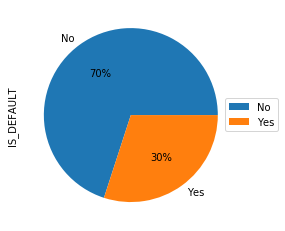

In [8]:
#cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',colormap='winter',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))
cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))

# Default by Credit Program

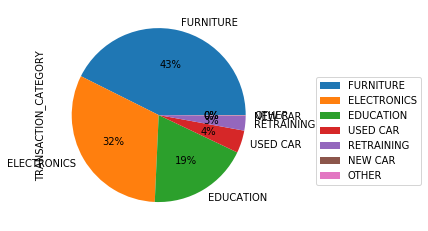

In [9]:
cust_pd.TRANSACTION_CATEGORY.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.7))

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23.4%) and Furniture(18.1%).

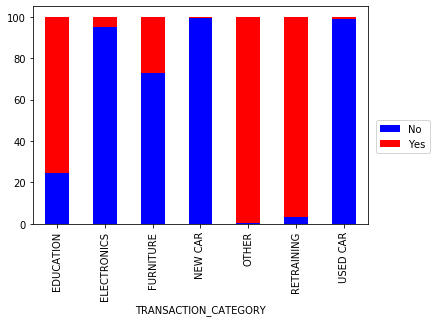

In [10]:
defaults_by_credit_program = cust_pd.groupby(['TRANSACTION_CATEGORY','IS_DEFAULT']).size()
percentages = defaults_by_credit_program.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

* Top 3 credit programs with high default rate are Education(44%), New Car(38%), and Retraining(35.1%)


# Default by IS_STATE_BORDER


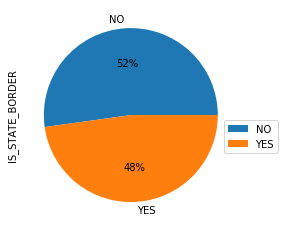

In [11]:
cust_pd.IS_STATE_BORDER.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.5))

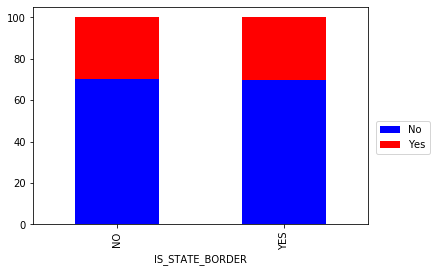

In [12]:
defaults_by_xborder = cust_pd.groupby(['IS_STATE_BORDER','IS_DEFAULT']).size()
percentages = defaults_by_xborder.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

# HAS_CO_APPLICANT vs. IS_DEFAULT

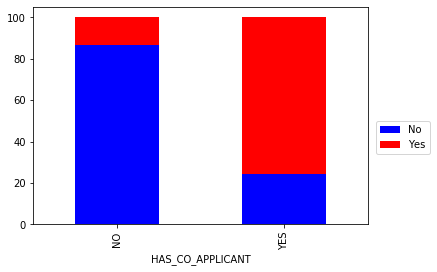

In [13]:
defaults_by_rent = cust_pd.groupby(['HAS_CO_APPLICANT','IS_DEFAULT']).size()
percentages = defaults_by_rent.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

From this stacked bar chart, we can see that Merchants who rent their residence have higher default rate.

# CREDIT_HISTORY vs. IS_DEFAULT

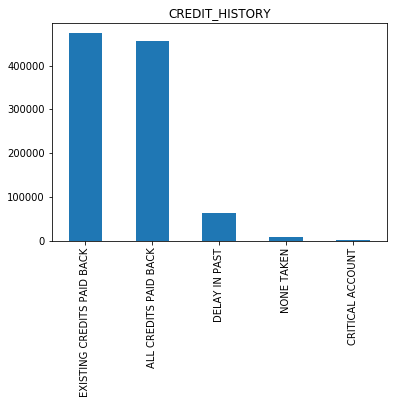

In [14]:
cust_pd.CREDIT_HISTORY.value_counts().plot(kind='bar', title='CREDIT_HISTORY')

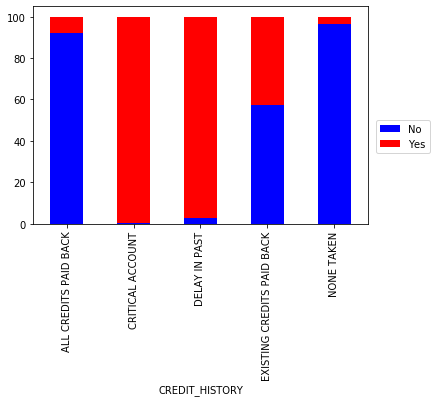

In [15]:
defaults_by_history = cust_pd.groupby(['CREDIT_HISTORY','IS_DEFAULT']).size()
percentages = defaults_by_history.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

# Data Preparation

In [16]:
#cust_pd = cust_pd.sort_values(['IS_DEFAULT'],ascending=[False])
#cust_pd = shuffle(cust_pd)
cust_pd = cust_pd_full
cust_pd.head()


,ACCOUNT_AGE,ACCOUNT_TYPE,CREDIT_HISTORY,EMI_TENURE,HAS_CO_APPLICANT,HAS_GUARANTOR,IS_DEFAULT,IS_STATE_BORDER,IS_URBAN,NUMBER_CREDITS,OTHER_INSTALMENT_PLAN,OWN_CAR,OWN_REAL_ESTATE,OWN_RESIDENCE,RFM_SCORE,SHIP_INTERNATIONAL,STATE,TRANSACTION_AMOUNT,TRANSACTION_CATEGORY
0,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,105,NO,YES,No,YES,YES,0,NO,YES,YES,YES,4,YES,CT,25788,EDUCATION
1,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,105,NO,NO,No,NO,YES,0,YES,YES,NO,NO,3,YES,CT,25788,FURNITURE
2,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,112,NO,NO,No,YES,YES,0,YES,YES,NO,NO,3,NO,CT,27630,FURNITURE
3,above 7 YRS,above 1000 K USD,ALL CREDITS PAID BACK,140,YES,NO,No,NO,YES,0,NO,NO,NO,NO,3,NO,PA,31314,USED CAR
4,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,98,YES,YES,Yes,NO,YES,0,YES,YES,NO,NO,4,NO,PA,25788,FURNITURE


## Split Dataframe into Features and Label

In [17]:
cust_pd_Y = cust_pd[['IS_DEFAULT']]
cust_pd_X = cust_pd.drop(['IS_DEFAULT'],axis=1)

print('cust_pd_X.shape=', cust_pd_X.shape, 'cust_pd_Y.shape=', cust_pd_Y.shape)


cust_pd_X.shape= (1000000, 18) cust_pd_Y.shape= (1000000, 1)


## Transform Label

In [18]:
cust_pd_Y.head()

,IS_DEFAULT
0,No
1,No
2,No
3,No
4,Yes


In [19]:
le = LabelEncoder()
cust_pd_Y['IS_DEFAULT'] = le.fit_transform(cust_pd_Y['IS_DEFAULT'])
cust_pd_Y.head()

,IS_DEFAULT
0,0
1,0
2,0
3,0
4,1


## Transform Features

In [20]:
print('features df shape = ', cust_pd_X.shape)
cust_pd_X.head()

features df shape =  (1000000, 18)


,ACCOUNT_AGE,ACCOUNT_TYPE,CREDIT_HISTORY,EMI_TENURE,HAS_CO_APPLICANT,HAS_GUARANTOR,IS_STATE_BORDER,IS_URBAN,NUMBER_CREDITS,OTHER_INSTALMENT_PLAN,OWN_CAR,OWN_REAL_ESTATE,OWN_RESIDENCE,RFM_SCORE,SHIP_INTERNATIONAL,STATE,TRANSACTION_AMOUNT,TRANSACTION_CATEGORY
0,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,105,NO,YES,YES,YES,0,NO,YES,YES,YES,4,YES,CT,25788,EDUCATION
1,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,105,NO,NO,NO,YES,0,YES,YES,NO,NO,3,YES,CT,25788,FURNITURE
2,up to 1 YR,UNKNOWN/NONE,EXISTING CREDITS PAID BACK,112,NO,NO,YES,YES,0,YES,YES,NO,NO,3,NO,CT,27630,FURNITURE
3,above 7 YRS,above 1000 K USD,ALL CREDITS PAID BACK,140,YES,NO,NO,YES,0,NO,NO,NO,NO,3,NO,PA,31314,USED CAR
4,up to 1 YR,above 1000 K USD,EXISTING CREDITS PAID BACK,98,YES,YES,NO,YES,0,YES,YES,NO,NO,4,NO,PA,25788,FURNITURE


### One hot encoding for categorical Columns

In [21]:
categoricalColumns = ['CREDIT_HISTORY', 'TRANSACTION_CATEGORY', 'ACCOUNT_TYPE', 'ACCOUNT_AGE',
                      'STATE', 'IS_URBAN', 'IS_STATE_BORDER', 'HAS_CO_APPLICANT', 'HAS_GUARANTOR',
                      'OWN_REAL_ESTATE', 'OTHER_INSTALMENT_PLAN',
                      'OWN_RESIDENCE', 'RFM_SCORE', 'OWN_CAR', 'SHIP_INTERNATIONAL']
cust_pd_X = pd.get_dummies(cust_pd_X, columns=categoricalColumns)

cust_pd_X.head()

,EMI_TENURE,NUMBER_CREDITS,TRANSACTION_AMOUNT,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,105,0,25788,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1
1,105,0,25788,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1
2,112,0,27630,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0
3,140,0,31314,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0
4,98,0,25788,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,0


## Normalize Features

In [22]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(cust_pd_X)
features = normalize(features, axis=1, norm='l1')

cust_pd_X = pd.DataFrame(features,columns=cust_pd_X.columns)
cust_pd_X.head()

,EMI_TENURE,NUMBER_CREDITS,TRANSACTION_AMOUNT,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,0.034473,0.0,0.034749,0.000000,0.0,0.0,0.062052,0.0,0.062052,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062052,0.0,0.0,0.0,0.0,0.000000,0.062052,0.062052,0.0,0.0,0.000000,0.0,0.062052,0.000000,0.062052,0.062052,0.000000,0.000000,0.062052,0.000000,0.062052,0.062052,0.000000,0.000000,0.062052,0.0,0.0,0.000000,0.062052,0.000000,0.062052,0.000000,0.062052
1,0.034473,0.0,0.034749,0.000000,0.0,0.0,0.062052,0.0,0.000000,0.0,0.062052,0.0,0.0,0.0,0.000000,0.0,0.0,0.062052,0.000000,0.0,0.0,0.0,0.0,0.000000,0.062052,0.062052,0.0,0.0,0.000000,0.0,0.062052,0.062052,0.000000,0.062052,0.000000,0.062052,0.000000,0.062052,0.000000,0.000000,0.062052,0.062052,0.000000,0.0,0.0,0.062052,0.000000,0.000000,0.062052,0.000000,0.062052
2,0.036597,0.0,0.037054,0.000000,0.0,0.0,0.061757,0.0,0.000000,0.0,0.061757,0.0,0.0,0.0,0.000000,0.0,0.0,0.061757,0.000000,0.0,0.0,0.0,0.0,0.000000,0.061757,0.061757,0.0,0.0,0.000000,0.0,0.061757,0.000000,0.061757,0.061757,0.000000,0.061757,0.000000,0.061757,0.000000,0.000000,0.061757,0.061757,0.000000,0.0,0.0,0.061757,0.000000,0.000000,0.061757,0.061757,0.000000
3,0.045110,0.0,0.041411,0.060899,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.060899,0.0,0.0,0.000000,0.060899,0.0,0.0,0.0,0.0,0.060899,0.000000,0.000000,0.0,0.0,0.060899,0.0,0.060899,0.060899,0.000000,0.000000,0.060899,0.060899,0.000000,0.060899,0.000000,0.060899,0.000000,0.060899,0.000000,0.0,0.0,0.060899,0.000000,0.060899,0.000000,0.060899,0.000000
4,0.032249,0.0,0.034829,0.000000,0.0,0.0,0.062195,0.0,0.000000,0.0,0.062195,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062195,0.0,0.0,0.0,0.0,0.000000,0.062195,0.000000,0.0,0.0,0.062195,0.0,0.062195,0.062195,0.000000,0.000000,0.062195,0.000000,0.062195,0.062195,0.000000,0.000000,0.062195,0.062195,0.000000,0.0,0.0,0.000000,0.062195,0.000000,0.062195,0.062195,0.000000


## Split Train and Test Dataset

In [23]:
label    = cust_pd_Y.values
features  = cust_pd_X.values

label = np.reshape(label,(-1,1))
X_train,X_test,y_train,y_test = \
       train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)




X_train.shape= (700000, 51) Y_train.shape= (700000, 1)
X_test.shape= (300000, 51) Y_test.shape= (300000, 1)


# Snapml Training

In [24]:
# Import the LogisticRegression from snap.ml
from snap_ml import LogisticRegression
snapml_lr = LogisticRegression(use_gpu=True, device_ids=[0], 
                        max_iter=10, num_threads=1024)


In [25]:
# Training
t0 = time.time()
snapml_lr.fit(X_train, y_train)
print("[snap.ml] Training time (s):  {0:.2f}".format(time.time()-t0))

[snap.ml] Training time (s):  4.66


In [26]:
# Evaluate accuracy on test set
snapml_prediction = snapml_lr.predict(X_test)
print('snap ml accuracy score = ', accuracy_score(y_test, snapml_prediction))

# proba_test = snapml_lr.predict_proba(X_test)
# from sklearn.metrics import log_loss
# logloss_snap = log_loss(y_test, proba_test)
# print("[snap.ml] Logarithmic loss:   {0:.4f}".format(logloss_snap))

snap ml accuracy score =  0.9700266666666667


# sklearn Train

In [27]:
# Import
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression(verbose=1)

In [28]:
# TRAIN
t0 = time.time()
sklearn_lr.fit(X_train, y_train)
print("[sklearn] Training time (s):  {0:.5f}".format(time.time()-t0))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[sklearn] Training time (s):  10.75089


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s finished


In [29]:
# Evaluate log-loss on test set
# proba_test = sklearn_lr.predict_proba(X_test)
# from sklearn.metrics import log_loss
# logloss_sklearn = log_loss(y_test, proba_test)
# print("[sklearn] Logarithmic loss:   {0:.4f}".format(logloss_sklearn))
sklearn_prediction = sklearn_lr.predict(X_test)
print('sklearn ml accuracy score = ', accuracy_score(y_test, sklearn_prediction))

sklearn ml accuracy score =  0.9701


&copy; Copyright IBM Corporation 2018, 2020